In [1]:
import pandas as pd
import os
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

os.chdir("P:/Courses/Kaggle/Coke MMA/mma-2020w-coke-kaggle3")

In [2]:
train=pd.read_csv("POS_OST_TRAIN_DATA.csv")
test=pd.read_csv("POS_OST_TEST_DATA.csv")


In [3]:
train.columns

Index(['BANNER', 'PRODUCT', 'WEEK_NAME', 'WEEK_TYPE', 'PACK_SUBTYPE',
       'FEATURE', 'PRICE', 'OFFER', 'MULTIPLE', 'EDV', 'VOLUME_RETAIL_UNITS',
       'SALES_DOLLARS', 'POS_YEAR_WEEK', 'SHIP_YEAR', 'SHIP_WEEK',
       'VOLUME_SHIPPED_RETAIL_UNITS'],
      dtype='object')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6895 entries, 0 to 6894
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BANNER                       6895 non-null   object 
 1   PRODUCT                      6895 non-null   object 
 2   WEEK_NAME                    6895 non-null   object 
 3   WEEK_TYPE                    4309 non-null   object 
 4   PACK_SUBTYPE                 6895 non-null   object 
 5   FEATURE                      3361 non-null   object 
 6   PRICE                        6895 non-null   float64
 7   OFFER                        3361 non-null   object 
 8   MULTIPLE                     3361 non-null   float64
 9   EDV                          6895 non-null   float64
 10  VOLUME_RETAIL_UNITS          6817 non-null   float64
 11  SALES_DOLLARS                6817 non-null   float64
 12  POS_YEAR_WEEK                6895 non-null   object 
 13  SHIP_YEAR         

In [5]:
train.head()

,BANNER,PRODUCT,WEEK_NAME,WEEK_TYPE,PACK_SUBTYPE,FEATURE,PRICE,OFFER,MULTIPLE,EDV,VOLUME_RETAIL_UNITS,SALES_DOLLARS,POS_YEAR_WEEK,SHIP_YEAR,SHIP_WEEK,VOLUME_SHIPPED_RETAIL_UNITS
0,BANNER1,TCCC CSD 12 X 355 ML CAN,Superbowl,Holiday,FREQUENCY,NaN,4.99,NaN,NaN,4.99,8862.0,57186.74,2017-05,2017,Week-05,7475.0
1,BANNER1,TCCC CSD 2 LT BTTL,Superbowl,Holiday,FREQUENCY,NaN,1.75,NaN,NaN,1.75,21836.0,49415.16,2017-05,2017,Week-05,16048.0
2,BANNER1,TCCC CSD 24 X 355 ML CAN,Superbowl,Holiday,FREQUENCY,FRONT PAGE,6.35,6.35,1.0,9.98,86407.0,548715.17,2017-05,2017,Week-05,68274.0
3,BANNER1,TCCC CSD 500 ML BTTL,Superbowl,Holiday,SINGLE SERVE,NaN,2.19,NaN,NaN,2.19,3087.0,6143.13,2017-05,2017,Week-05,2664.0
4,BANNER1,TCCC CSD 6 X 222 ML CAN,Superbowl,Holiday,TRANSACTION,IN STORE,2.50,2/$5,2.0,2.99,10210.0,25524.48,2017-05,2017,Week-05,9152.0


In [6]:
# Data missing information 
data_info=pd.DataFrame(train.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_info=data_info.append(pd.DataFrame(train.isnull().sum()/train.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(data_info)

,BANNER,PRODUCT,WEEK_NAME,WEEK_TYPE,PACK_SUBTYPE,FEATURE,PRICE,OFFER,MULTIPLE,EDV,VOLUME_RETAIL_UNITS,SALES_DOLLARS,POS_YEAR_WEEK,SHIP_YEAR,SHIP_WEEK,VOLUME_SHIPPED_RETAIL_UNITS
column type,object,object,object,object,object,object,float64,object,float64,float64,float64,float64,object,int64,object,float64
null values (nb),0,0,0,2586,0,3534,0,3534,3534,0,78,78,0,0,0,0
null values (%),0,0,0,37.5054,0,51.2545,0,51.2545,51.2545,0,1.13125,1.13125,0,0,0,0


In [7]:
train['MULTIPLE'] = np.where(train['MULTIPLE'].isna(), 0, train['MULTIPLE'])

In [8]:
train['OFFER'] = np.where(train['OFFER'].isna(), 0, train['OFFER'])

In [9]:
train[['OFFER','OFFER_NEW']] = train['OFFER'].str.split('$',expand=True)

In [10]:
train['OFFER_NEW'] = np.where((train['OFFER_NEW'].isna() & train['OFFER'].isna()),0, train['OFFER_NEW'])

In [11]:
train.OFFER_NEW.fillna(value=np.nan, inplace=True)

In [12]:
train['OFFER_NEW'] = np.where(train['OFFER_NEW'].isna(),train['OFFER'],train['OFFER_NEW'] )

In [13]:
train.head()

,BANNER,PRODUCT,WEEK_NAME,WEEK_TYPE,PACK_SUBTYPE,FEATURE,PRICE,OFFER,MULTIPLE,EDV,VOLUME_RETAIL_UNITS,SALES_DOLLARS,POS_YEAR_WEEK,SHIP_YEAR,SHIP_WEEK,VOLUME_SHIPPED_RETAIL_UNITS,OFFER_NEW
0,BANNER1,TCCC CSD 12 X 355 ML CAN,Superbowl,Holiday,FREQUENCY,NaN,4.99,NaN,0.0,4.99,8862.0,57186.74,2017-05,2017,Week-05,7475.0,0
1,BANNER1,TCCC CSD 2 LT BTTL,Superbowl,Holiday,FREQUENCY,NaN,1.75,NaN,0.0,1.75,21836.0,49415.16,2017-05,2017,Week-05,16048.0,0
2,BANNER1,TCCC CSD 24 X 355 ML CAN,Superbowl,Holiday,FREQUENCY,FRONT PAGE,6.35,6.35,1.0,9.98,86407.0,548715.17,2017-05,2017,Week-05,68274.0,6.35
3,BANNER1,TCCC CSD 500 ML BTTL,Superbowl,Holiday,SINGLE SERVE,NaN,2.19,NaN,0.0,2.19,3087.0,6143.13,2017-05,2017,Week-05,2664.0,0
4,BANNER1,TCCC CSD 6 X 222 ML CAN,Superbowl,Holiday,TRANSACTION,IN STORE,2.50,2/,2.0,2.99,10210.0,25524.48,2017-05,2017,Week-05,9152.0,5


In [14]:
test['MULTIPLE'] = np.where(test['MULTIPLE'].isna(), 0, test['MULTIPLE'])

In [15]:
test['OFFER'] = np.where(test['OFFER'].isna(), 0, test['OFFER'])

In [16]:
test[['OFFER','OFFER_NEW']] = test['OFFER'].str.split('$',expand=True)

In [17]:
test['OFFER_NEW'] = np.where((test['OFFER_NEW'].isna() & test['OFFER'].isna()),0, test['OFFER_NEW'])

In [18]:
test.OFFER_NEW.fillna(value=np.nan, inplace=True)

In [19]:
test['OFFER_NEW'] = np.where(test['OFFER_NEW'].isna(),test['OFFER'],test['OFFER_NEW'] )

In [20]:
test.head()

,RECORDID,BANNER,PRODUCT,WEEK_NAME,WEEK_TYPE,PACK_SUBTYPE,FEATURE,PRICE,OFFER,MULTIPLE,EDV,POS_YEAR_WEEK,SHIP_YEAR,SHIP_WEEK,OFFER_NEW
0,1,BANNER1,TCCC CSD 12 X 355 ML CAN,Week 45,NaN,FREQUENCY,IN STORE,5.49,5.49,1.0,5.49,2019-45,2019,Week-45,5.49
1,2,BANNER1,TCCC CSD 2 LT BTTL,Week 45,NaN,FREQUENCY,IN STORE,1.99,1.99,1.0,1.99,2019-45,2019,Week-45,1.99
2,3,BANNER1,TCCC CSD 24 X 355 ML CAN,Week 45,NaN,FREQUENCY,NaN,10.02,NaN,0.0,10.02,2019-45,2019,Week-45,0
3,4,BANNER1,TCCC CSD 500 ML BTTL,Week 45,NaN,SINGLE SERVE,NaN,2.19,NaN,0.0,2.19,2019-45,2019,Week-45,0
4,5,BANNER1,TCCC CSD 6 X 222 ML CAN,Week 45,NaN,TRANSACTION,IN STORE,2.99,2.99,1.0,2.99,2019-45,2019,Week-45,2.99


In [21]:
test.dtypes

RECORDID           int64
BANNER            object
PRODUCT           object
WEEK_NAME         object
WEEK_TYPE         object
PACK_SUBTYPE      object
FEATURE           object
PRICE            float64
OFFER             object
MULTIPLE         float64
EDV              float64
POS_YEAR_WEEK     object
SHIP_YEAR          int64
SHIP_WEEK         object
OFFER_NEW         object
dtype: object

In [22]:
train['OFFER_NEW']=pd.to_numeric(train['OFFER_NEW'], errors='coerce')

In [23]:
test['OFFER_NEW']=pd.to_numeric(test['OFFER_NEW'], errors='coerce')

In [24]:
train['EFF_OFFER']=train['MULTIPLE']* train['OFFER_NEW']

In [25]:
test['EFF_OFFER']=test['MULTIPLE']* test['OFFER_NEW']

In [26]:
# Data missing information 
#data_info1=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
#data_info1=data_info1.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
#data_info1=data_info1.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
#                         rename(index={0:'null values (%)'}))
#display(data_info1)
train.isnull().sum().sum()

9810

In [27]:
train = train.drop(['VOLUME_RETAIL_UNITS','SALES_DOLLARS'], axis=1)



In [28]:

from pycaret.regression import *
reg_setup = setup(data= train, target='VOLUME_SHIPPED_RETAIL_UNITS',remove_outliers=True,normalize=True, ignore_low_variance = True, 
                             remove_multicollinearity=True ,normalize_method='robust', train_size=0.8, feature_interaction=True,
                             feature_selection=True ,interaction_threshold=0.1,silent = True,session_id = 65)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,65
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(6895, 16)"
4,Missing Values,True
5,Numeric Features,5
6,Categorical Features,10
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
compare_models()

In [85]:
en_model = create_model('en')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8092.6364,196710236.0476,14025.3426,0.7135,1.5233,6.1201
1,8446.8653,248453009.0010,15762.3922,0.6483,1.5566,2.3932
2,7867.9904,271633484.1591,16481.3071,0.5166,1.6547,57.5824
3,8410.0947,248434096.3879,15761.7923,0.6872,1.5909,-18.8820
4,8049.1776,211020788.8550,14526.5546,0.6587,1.5713,-45.5739
5,8470.2346,234109853.0680,15300.6488,0.6823,1.5612,6.0624
6,8191.9601,249059242.3669,15781.6109,0.6199,1.6319,-3.4758
7,8074.5453,207904063.3372,14418.8787,0.7020,1.6523,15.4375
8,7912.8828,178001483.7367,13341.7197,0.6994,1.3977,1.3747
9,7242.9908,146667433.3312,12110.6331,0.7483,1.5035,-0.0910


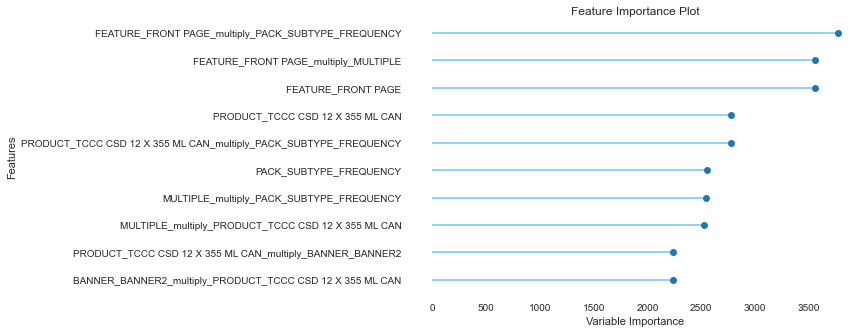

In [60]:
plot_model(estimator = en_model, plot = 'feature')

In [61]:
gbr_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4255.1426,49947471.4514,7067.3525,0.9093,1.2786,2.3431
1,4397.8282,78395646.2555,8854.1316,0.8649,1.2817,10.3433
2,4182.8149,69162176.4938,8316.3800,0.8863,1.3201,18.3760
3,4145.1321,47700924.5423,6906.5856,0.9220,1.3116,-9.8802
4,4258.1787,71959755.9239,8482.9096,0.9027,1.2545,36.4802
5,4698.4878,92014174.1798,9592.4019,0.8743,1.3777,-39.8460
6,4402.6934,65422943.1787,8088.4450,0.9076,1.3535,-3.0087
7,4183.1555,55050570.5313,7419.6072,0.9287,1.1997,1.6695
8,4244.6174,56190474.6181,7496.0306,0.9193,1.3319,-4.3385
9,4127.4784,62402178.2035,7899.5049,0.8938,1.2481,-14.4966


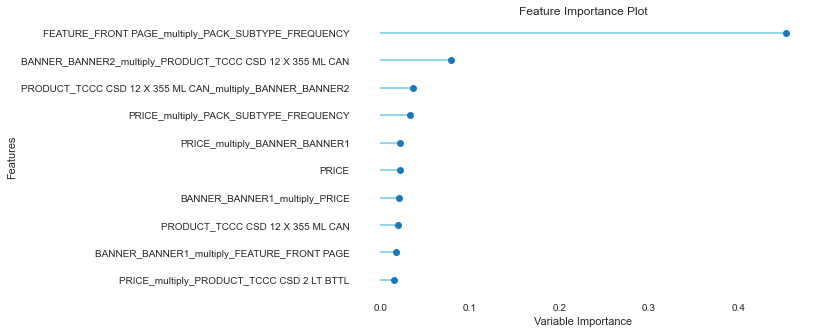

In [62]:
plot_model(estimator = gbr_model, plot = 'feature')

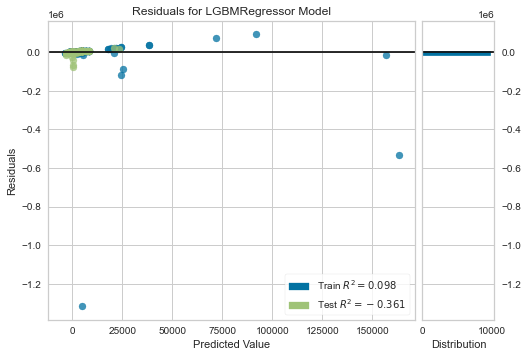

In [31]:
plot_model(gbr_model)

In [63]:
pred_gbr = predict_model(gbr_model, data=test)

In [64]:
pred_gbr.to_csv("Pred_GBR_Py2.csv")

In [86]:
best=automl(optimize='MAE')

In [87]:
best

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=65, selection='cyclic', tol=0.0001, warm_start=False)

In [71]:
best

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=65, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [88]:
pred_auto = predict_model(best, data=test)

In [89]:
pred_auto.to_csv("Pred_autoML_Py3.csv")

In [50]:
#stacking 2 models
blend = blend_models(estimator_list=[best,en_model])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7041.9948,113358273.5044,10646.9842,0.7941,1.6552,7.2153
1,7098.6237,173133993.6684,13158.0391,0.7016,1.6634,31.1917
2,7311.5658,180196832.3296,13423.7414,0.7037,1.6672,32.4174
3,7962.3470,153821934.9144,12402.4971,0.7484,1.7278,-27.6687
4,8023.3354,258966419.4778,16092.4336,0.6499,1.5891,18.6313
5,8036.8930,211897023.9681,14556.6831,0.7106,1.7404,-38.8574
6,8246.0498,221515424.9701,14883.3943,0.6871,1.7875,-11.5291
7,8129.5833,274070252.8214,16555.0673,0.6452,1.6184,3.5032
8,7838.7781,164304812.3575,12818.1439,0.7639,1.7348,-19.4146
9,7136.9562,138196579.6926,11755.7041,0.7648,1.6367,-23.9703


In [ ]:
plot_model(blend, plot='auc')

In [ ]:
plot_model(estimator = blend, plot = 'confusion_matrix')

In [ ]:
plot_model(estimator = blend, plot = 'feature')

In [ ]:
pred_blend = predict_model(blend, data=test2)

In [ ]:
pred_blend

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(test['Class'], pred_blend['Label']))

In [ ]:
tuned_blend = tune_model('et')